In [1]:
import itertools
from copy import deepcopy as copy
from utils.Conversions import partial 
# from netgraph import InteactiveGraph # pip install netgraph
from functools import reduce
from itertools import chain, permutations, product
from operator import itemgetter
from time import time

import cvxpy as cp
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy
from numpy.linalg import matrix_rank as rank
from scipy.linalg import block_diag, fractional_matrix_power
from utils.Adversary import Adversary
from utils.Conversions import hamming_dist as dist
from utils.Conversions import (
    mask_maker,
    partial,
    to_adversary_mat,
    to_str,
    to_str_list,
    visualize,
)
from utils.Problems import ED, Problem, exact_k, threshold_k
from utils.Solvers import (
    adv_solver,
    instance_mask,
    ket,
    relative_hadamard_norm_max,
    type_mask,
)

mpl.rcParams["figure.dpi"] = 120
from multiprocessing.pool import ThreadPool as Pool

In [2]:
def get_oracles(funcs, oracle_getter, to_list=True):
    print("get_oracles", len(funcs))
    if to_list:
        return [oracle_getter(func) for func in funcs]
    return {func: oracle_getter(func) for func in funcs}


def cycle_oracle(func):
    return permutation_oracle(cycle_to_standard(func))


def get_phase_oracles(problem):
    oracles = {}
    # roots = nthRootsOfUnity(n)
    if isinstance(problem, Problem):
        instances = problem.instances
    n = len(instances[0])
    for instance in instances:
        oracle = np.zeros((n, n))
        for i in range(n):
            oracle[i, i] = -1 if instance[i] == 1 else 1
        oracles[instance] = oracle

    return oracles


def phase_oracle(func):
    oracle = np.zeros((len(func), len(func)))
    for i in range(len(func)):
        oracle[i, i] = func[i]
    return oracle


def get_standard_oracles(problem):
    oracles = {}
    n = problem.n
    alpha_len = len(problem.alphabet)
    for instance in problem.instances:
        oracle = []
        for i in range(n):
            curr_oracle = np.zeros((alpha_len, alpha_len))
            for a in problem.alphabet:
                curr_oracle[a, (instance[i] + a) % alpha_len] = 1
            # print(curr_oracle)
            oracle.append(copy(curr_oracle))
        oracles[instance] = block_diag(*oracle)
        # print(oracles[instance])
    return oracles


def standard_oracle(func, alpha_len=None):
    n = len(func)
    if alpha_len is None:
        alpha_len = n
    oracle = []
    for i in range(n):
        curr_oracle = np.zeros((alpha_len, alpha_len))
        for a in range(alpha_len):
            curr_oracle[a, (func[i] + a) % alpha_len] = 1
            # print(curr_oracle)
        oracle.append(copy(curr_oracle))
    return block_diag(*oracle)


def get_oracle_diffs(oracles, prod=True, mat=False, keys=None, threads=8):
    n = oracles[0].shape[0]
    if np.linalg.norm(np.imag(np.block([oracles]))) == 0:
        oracle_diffs = np.zeros([n * len(oracles)] * 2)
    else:
        print("complex time!")
        oracle_diffs = np.zeros([n * len(oracles)] * 2, dtype=complex)
    # print("keys", keys)
    I = np.eye(oracles[0].shape[0])
    if keys is None:
        keys = list(range(len(oracles)))
    # keys.sort()
    keys = list(range(len(oracles)))

    def diff_map(v):
        v1, v2 = v
        return I - oracles[v1].conj().T @ oracles[v2]

    # counter = 0
    pool = Pool(threads)
    for v1 in keys:
        if not v1 % 100:
            print(v1 / len(oracles))
        oracle_diffs[v1 * n : (v1 + 1) * n] = np.hstack(
            pool.map(diff_map, list(product([v1], keys)))
        )
    return oracle_diffs


def phase_oracle_diffs(perms):
    # phase_mats = [permutation_oracle(perm) for perm in perms]
    diffs = [[_ for _ in range(len(perms))] for _2 in range(len(perms))]
    # print('diffs', diffs)
    n = len(perms[0])
    for i in range(len(perms)):
        for j in range(len(perms)):
            diff = np.zeros((len(perms[i]), len(perms[i])))
            for r in range(n):
                # for c in range(n):
                if perms[i][r] != perms[j][r]:
                    diff[r, r] = 1
            # print('ij', i, j)
            diffs[i][j] = diff
    return diffs


def permutation_oracle(perm, nonstandard=False):
    n = len(perm)

    oracle = np.zeros((n, n))
    for i in range(n):
        oracle[perm[i], i] = 1
    return oracle


def get_permutation_oracles(instances):
    # assuming instances are all lists representing permutations
    oracles = {}
    n = len(instances[0])
    print(n)
    # assert tuple(range(n)) == problem.alphabet
    for instance in instances:
        oracle = np.zeros((n, n))
        for i in range(n):
            oracle[i, instance[i]] = 1
        oracles[instance] = oracle
        # assert oracle@oracle.T - np.eye(n)
    return oracles


def preimage_even_odd(n):
    perms = itertools.permutations(range(n))
    no_instances = []
    yes_instances = []
    for perm in get_cycles(n, n):
        # print(to_str(perm))
        if perm.index(0) >= n // 2:
            yes_instances.append(perm)
        else:
            no_instances.append(perm)
    return Problem(no_instances, yes_instances)

6


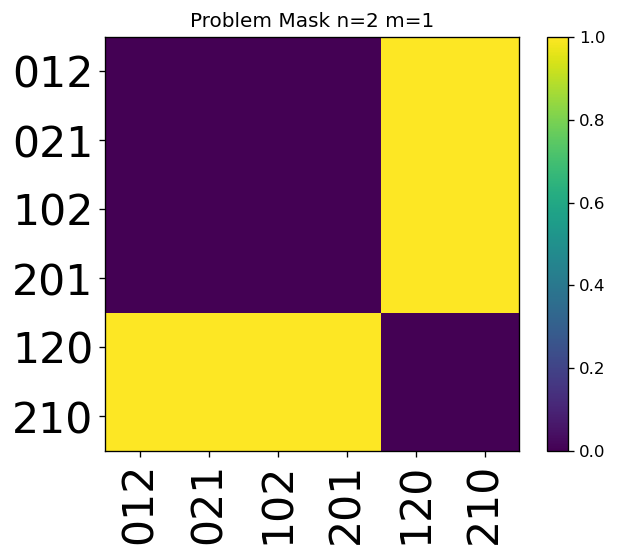

In [3]:
def mask_maker(cases, assignment=None):
    perms = None
    if assignment is None:
        perms = list(chain(*cases))
        assignment = {perm: i for i, perm in enumerate(perms)}
    mat = np.zeros((len(assignment), len(assignment)))
    for case1 in range(len(cases)):
        for case2 in range(len(cases)):
            if case1 != case2:
                for perm1 in cases[case1]:
                    for perm2 in cases[case2]:
                        mat[assignment[perm1], assignment[perm2]] = 1

    return mat


def inversion_sorter(perms):
    n = len(perms)
    perm_classes = [[perm for perm in perms if perm.index(0) == i] for i in range(n)]
    for pc in perm_classes:
        pc.sort()
    return list(chain(*perm_classes))


perm_len = 3
n = 2
m = perm_len - n
perms = list(permutations(range(perm_len)))
perms = inversion_sorter(perms)
print(len(perms))

cases = [
    [perm for perm in perms if perm.index(0) < n],
    [perm for perm in perms if perm.index(0) >= n],
]
problem_mat = mask_maker(cases)
labels = to_str_list(perms)
labels = [labels, labels]
visualize(problem_mat, labels, title="Problem Mask" + " n=" + str(n) + " m=" + str(m))

[array([[0., 0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1.],
       [1., 1., 0., 1., 0., 1.],
       [1., 1., 1., 0., 1., 0.],
       [1., 1., 0., 1., 0., 1.],
       [1., 1., 1., 0., 1., 0.]]), array([[0., 1., 1., 1., 1., 0.],
       [1., 0., 1., 1., 0., 1.],
       [1., 1., 0., 0., 1., 1.],
       [1., 1., 0., 0., 1., 1.],
       [1., 0., 1., 1., 0., 1.],
       [0., 1., 1., 1., 1., 0.]]), array([[0., 1., 0., 1., 1., 1.],
       [1., 0., 1., 0., 1., 1.],
       [0., 1., 0., 1., 1., 1.],
       [1., 0., 1., 0., 1., 1.],
       [1., 1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 0., 0.]])]


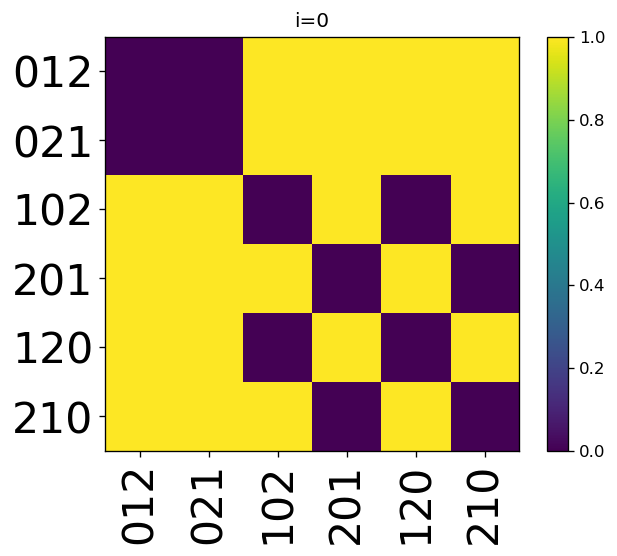

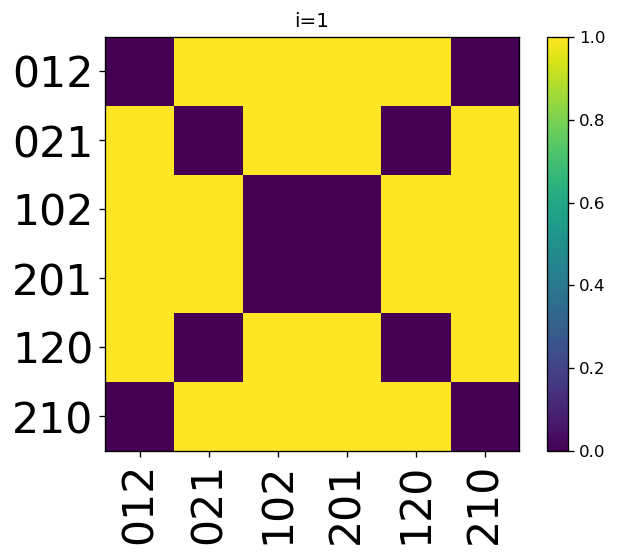

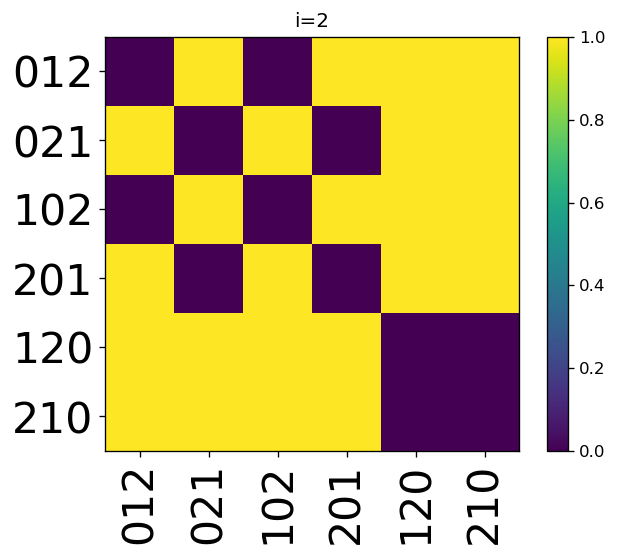

In [4]:
partials = [partial(perms, i) for i in range(perm_len)]
print(partials)
for i, part in enumerate(partials):
    visualize(part, labels, title="i=" + str(i))

get_oracles 6
0.0
shapes
(18, 18)
(3, 3)
                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Jan 20 04:36:37 PM: Your problem has 72 variables, 325 constraints, and 0 parameters.
(CVXPY) Jan 20 04:36:37 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 20 04:36:37 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 20 04:36:37 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 20 04:36:37 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 20 04:36:37 PM: C

C:\Users\Blake\ED_Adversaries\utils\Conversions.py:299: ComplexWarning: Casting complex values to real discards the imaginary part
  G[x,y] = Lambda[x,y]/np.sqrt(mu[x,x] * mu[y,y])


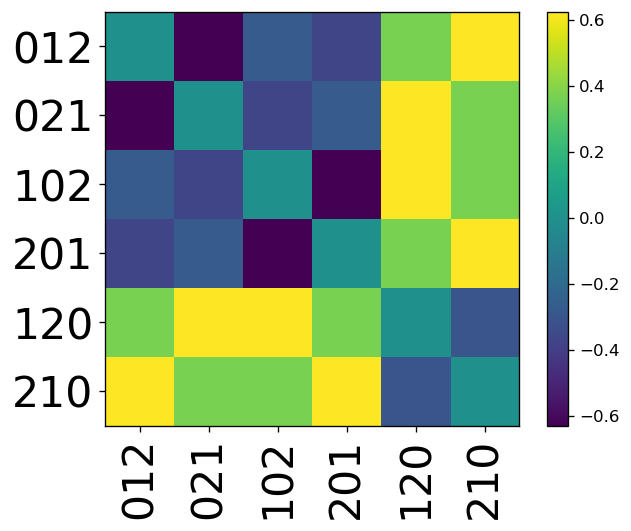

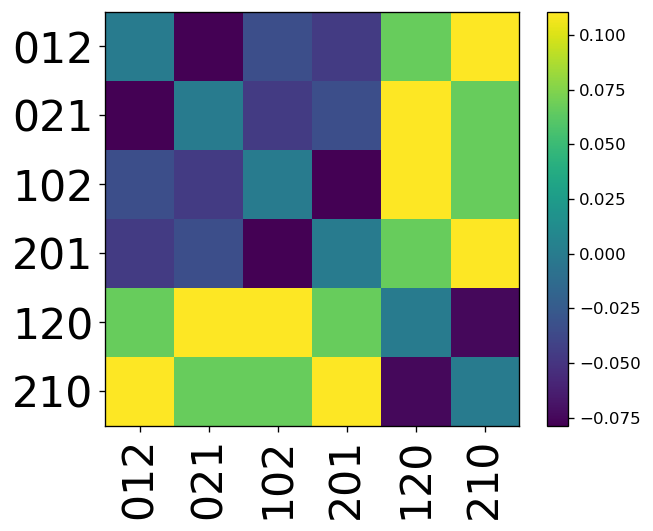

{0.0, -0.63085, -0.36915, 0.37486, -0.26883, 0.62514, -0.30004}


In [22]:
oracles = get_oracles(perms, permutation_oracle)
oracle_diffs = get_oracle_diffs(oracles)
oracle_diff_diffs = np.block(phase_oracle_diffs(perms))
oracle_diffs = oracle_diff_diffs
Lambda, Y, W = relative_hadamard_norm_max(problem_mat, oracle_diffs, len(perms))
G = to_adversary_mat(Lambda, Y)
visualize(G, labels)
visualize(Lambda, labels)
# visualize(np.linalg.eigh(Lambda)[1])
# Lambda_diff, Y_diff, W_diff = relative_hadamard_norm_max(
# problem_mat, oracle_diff_diffs, len(perms)
# )
print(set(np.round(G.flatten(), 5)))

C:\Users\Blake\ED_Adversaries\utils\Conversions.py:299: ComplexWarning: Casting complex values to real discards the imaginary part
  G[x,y] = Lambda[x,y]/np.sqrt(mu[x,x] * mu[y,y])


[(0, 1, 2), (1, 0, 2)]
[(0, 1, 2), (0, 2, 1)]


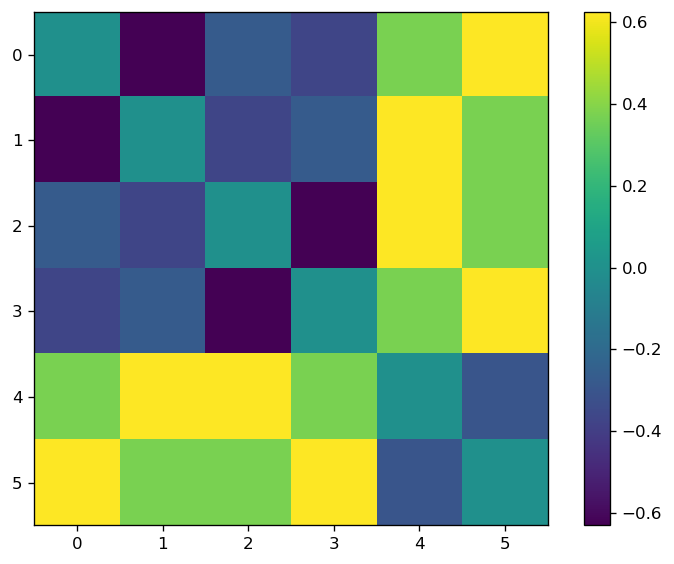

NameError: name 'mat' is not defined

In [14]:
G = to_adversary_mat(Lambda_diff, Y)


# permutations that preserve preimage type
def get_index_perms(n, m):
    perms_n = list(permutations(range(n)))
    perms_m = list(permutations(range(n, n + m)))
    index_perms = []
    for pn, pm in product(perms_n, perms_m):
        index_perms.append(pn + pm)
    return index_perms


def get_alpha_perms(n, m):
    nonzero_perms = list(permutations(range(1, n + m)))
    return [(0,) + perm for perm in nonzero_perms]


def apply_index_perm(perm, instance):
    new_instance = []
    for i in perm:
        new_instance.append(instance[i])
    return tuple(new_instance)


def apply_alpha_perm(perm, instance):
    new_instance = []
    for i in instance:
        new_instance.append(perm[i])
    return tuple(new_instance)


def perm_to_mat(permi, perma, instances):
    d = len(instances)
    mat = np.zeros((d, d))
    n = len(instances[0])
    instance_dict = {instance: i for i, instance in enumerate(instances)}
    for i, instance in enumerate(instances):
        image = apply_index_perm(permi, apply_alpha_perm(perma, instance))
        mat[instance_dict[image], i] = 1

    return mat


index_perms = get_index_perms(n, m)
alpha_perms = get_alpha_perms(n, m)
print(index_perms)
print(alpha_perms)
visualize(G)
visualize(mat @ G)
mat = perm_to_mat(index_perms[1], alpha_perms[0], perms)
mats = [
    perm_to_mat(permi, perma, perms)
    for permi, perma in product(index_perms, alpha_perms)
]
visualize(mat, labels)

In [ ]:
def tensor_mult(A, B):
    a = A.shape[0]
    b = B.shape[0]
    if a >= b:
        big = A
        small = B
    else:
        big = B
        small = A

    return big * np.kron(small, np.ones((big.shape[0] // small.shape[0],) * 2))


G = to_adversary_mat(Lambda, Y)
G_diff_diffs = to_adversary_mat(Lambda_diff, Y_diff)
visualize(G, labels)
visualize(G_diff_diffs, labels)
G_diff = tensor_mult(
    G,
    oracle_diffs,
)
truncated = tensor_mult(G * problem_mat, oracle_diffs)
evals, evects = np.linalg.eigh(G_diff)
tevals, tevects = np.linalg.eigh(truncated)
evals = np.round(evals, 3)
tevals = np.round(tevals, 3)
print(np.max(evals), np.min(evals))
print(np.max(tevals), np.min(tevals))

In [ ]:
visualize(np.where(np.abs(G_diff_diffs) >= 0.1, G_diff_diffs, 0), labels)
G_dt = np.where(np.abs(G_diff_diffs) >= 0.1, G_diff_diffs, 0)
p = partial(perms, 0)
G_dt = p * G_dt
print(np.max(np.linalg.eigvalsh(G_dt)), np.max(np.linalg.eigvalsh(G_dt * problem_mat)))
visualize(p, labels)
visualize(G_dt)
visualize((problem_mat * G_dt) @ (problem_mat * G_dt))
visualize(G_dt @ G_dt)

True
plen 6
(0, 1, 2, 3, 4, 5)
done [1. 0. 1. 1. 1. 1. 1.]
plen 6
(0, 2, 1, 5, 4, 3)
done [1. 0. 1. 1. 1. 1. 1.]
[[[ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  2.  0.  0.]
  [ 0.  0.  0.  0. -4.  1.  0.]
  [ 0.  0.  0.  0.  2. -2.  2.]
  [ 0.  0.  0.  0.  0.  1. -4.]
  [ 0.  0.  0.  0.  0.  0.  2.]]

 [[ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0. -4.  1.  0.]
  [ 0.  0.  0.  0.  8. -5.  0.]
  [ 0.  0.  0.  0. -4.  7. -4.]
  [ 0.  0.  0.  0.  0. -3.  8.]
  [ 0.  0.  0.  0

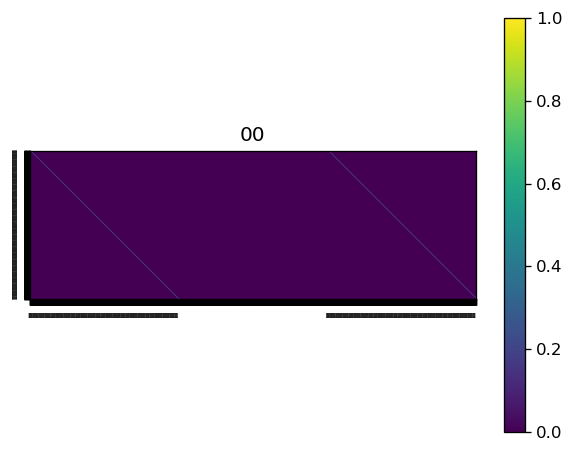

1 0
A_1A_0= 


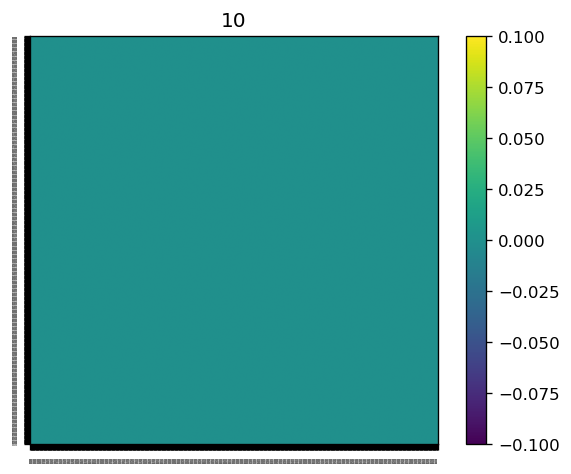

1 1
A_1A_1= 


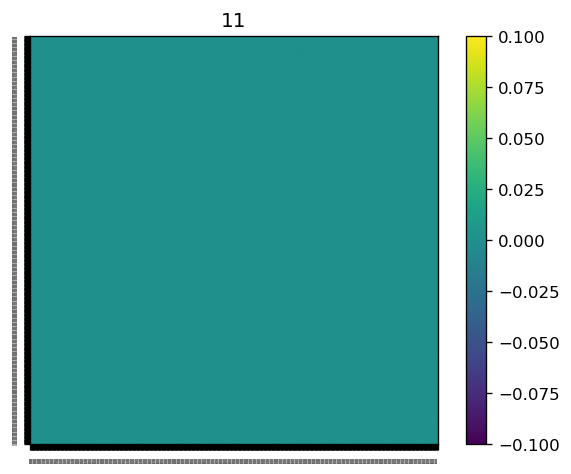

2 0
A_2A_0= 1A_2 + 


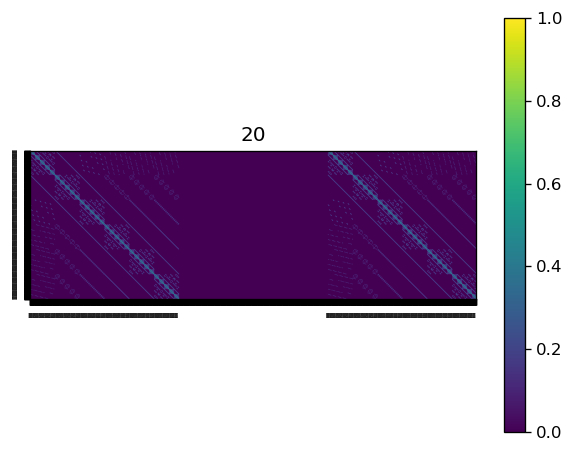

2 1
A_2A_1= 


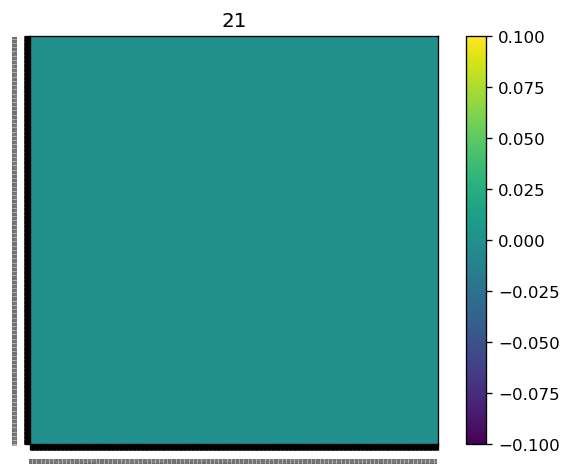

2 2
A_2A_2= 15A_0 + 3A_3 + 2A_4 + 


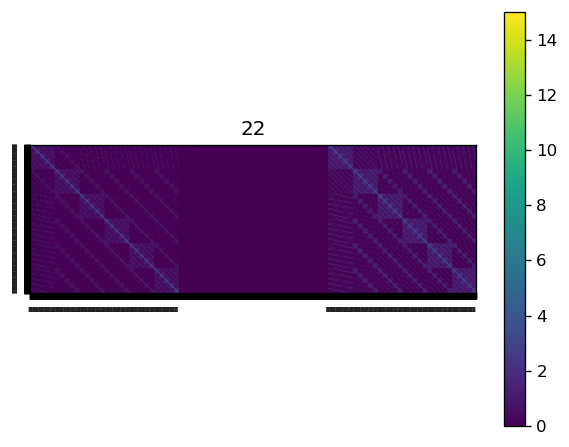

3 0
A_3A_0= 1A_3 + 


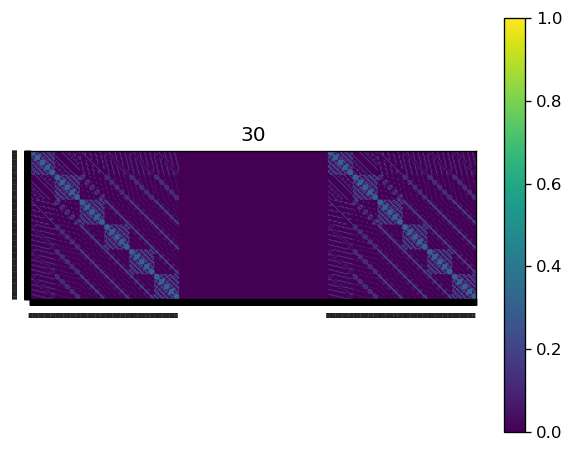

3 1
A_3A_1= 


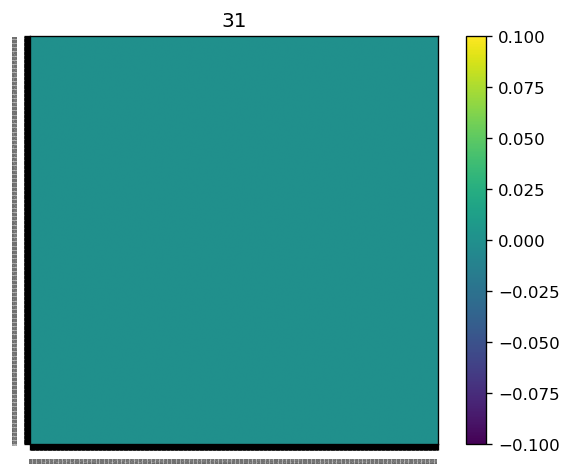

3 2
A_3A_2= 8A_2 + 1A_5 + 


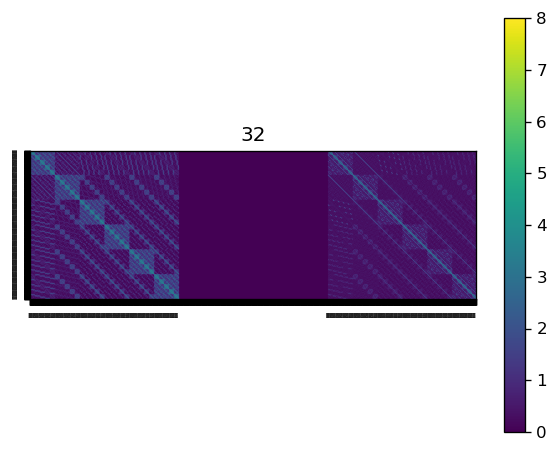

3 3
A_3A_3= 40A_0 + 10A_3 + 8A_4 + 


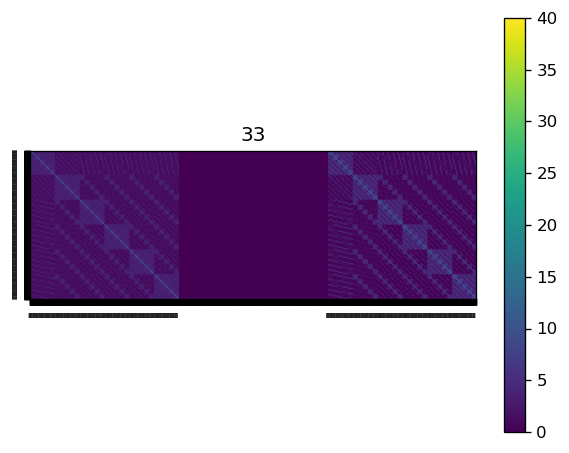

4 0
A_4A_0= 1A_4 + 


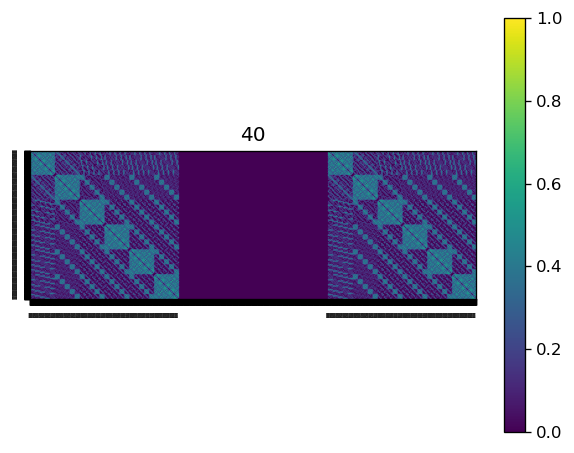

4 1
A_4A_1= 


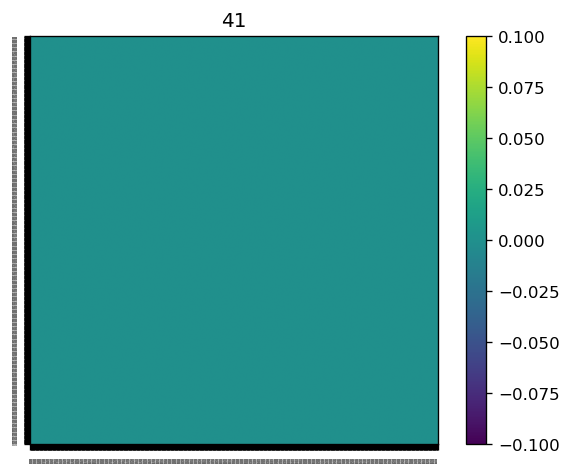

4 2
A_4A_2= 6A_2 + 9A_3 + 4A_4 + 3A_5 + 3A_6 + 


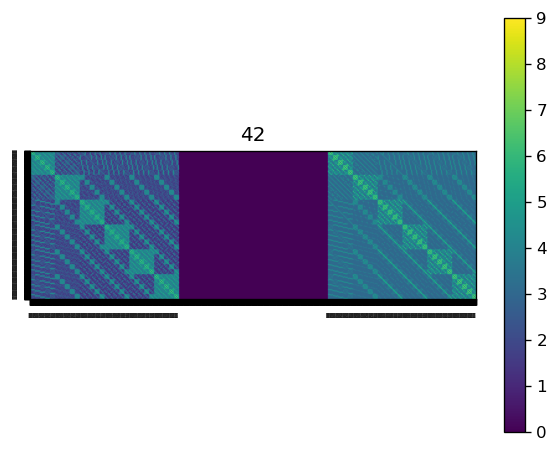

4 3
A_4A_3= 24A_2 + 9A_3 + 8A_4 + 12A_5 + 


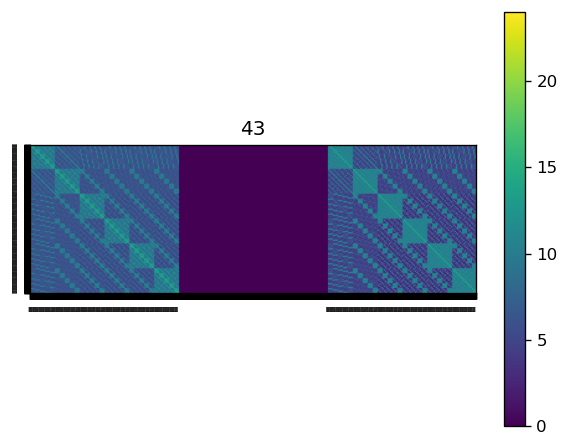

4 4
A_4A_4= 135A_0 + 24A_2 + 36A_3 + 38A_4 + 18A_5 + 24A_6 + 


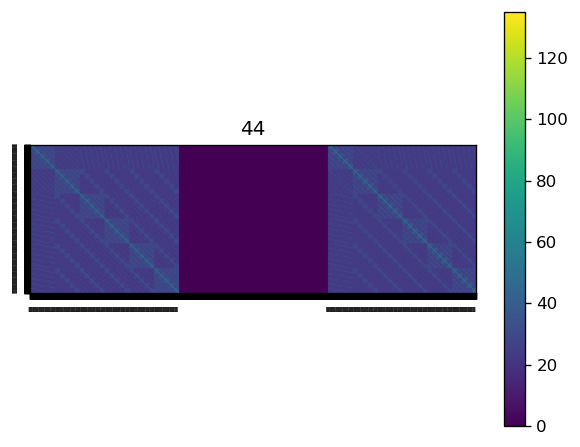

5 0
A_5A_0= 1A_5 + 


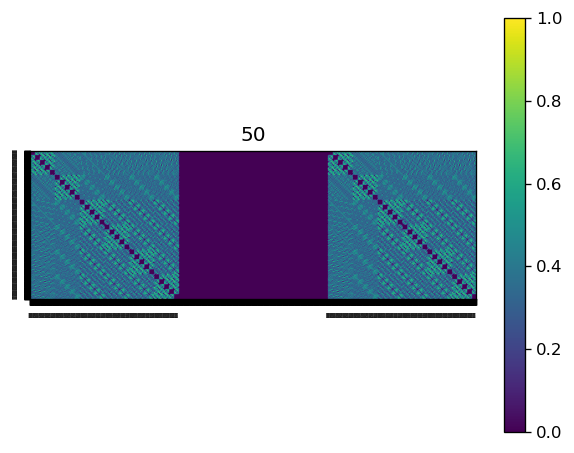

5 1
A_5A_1= 


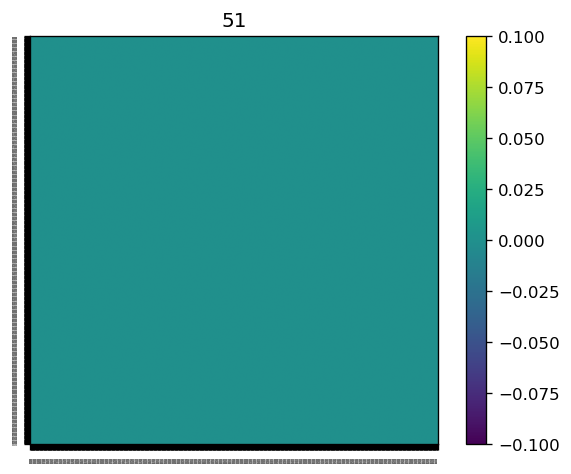

5 2
A_5A_2= 3A_3 + 8A_4 + 6A_5 + 


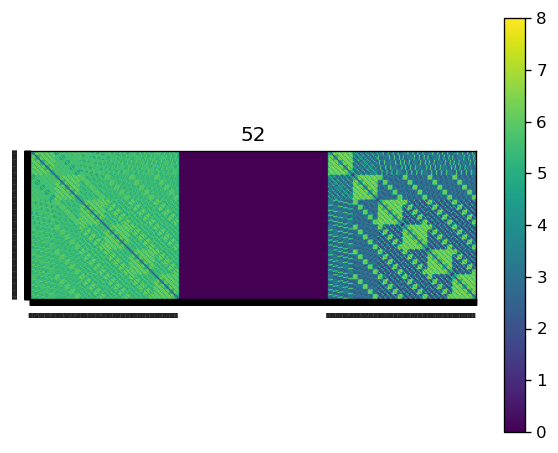

5 3
A_5A_3= 8A_2 + 18A_3 + 16A_4 + 12A_5 + 24A_6 + 


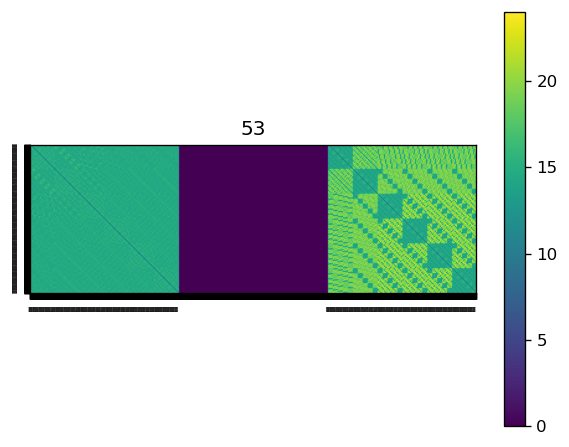

5 4
A_5A_4= 72A_2 + 54A_3 + 40A_4 + 51A_5 + 48A_6 + 


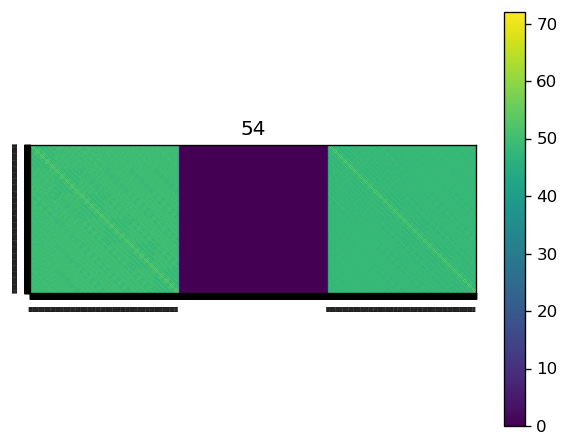

5 5
A_5A_5= 264A_0 + 96A_2 + 90A_3 + 104A_4 + 96A_5 + 96A_6 + 


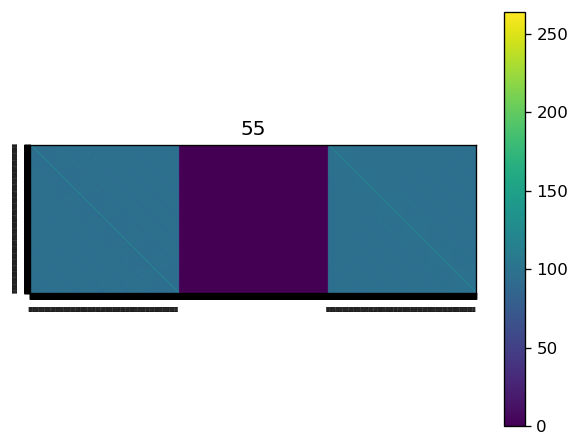

6 0
A_6A_0= 1A_6 + 


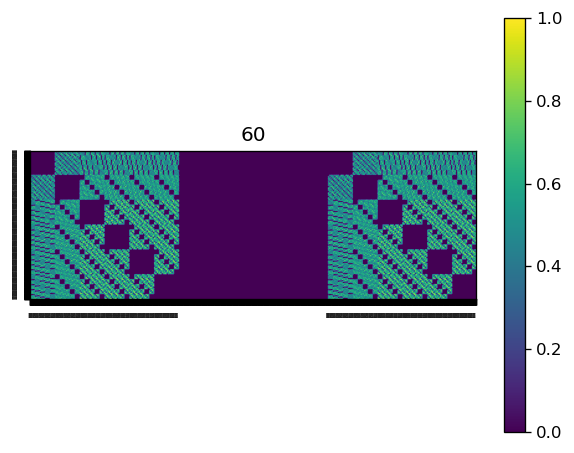

6 1
A_6A_1= 


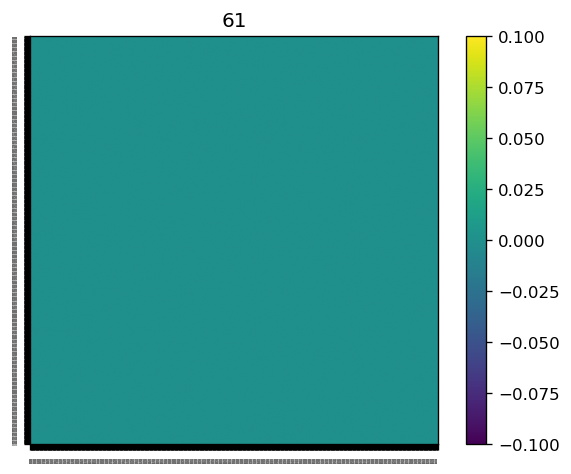

6 2
A_6A_2= 1A_4 + 5A_5 + 12A_6 + 


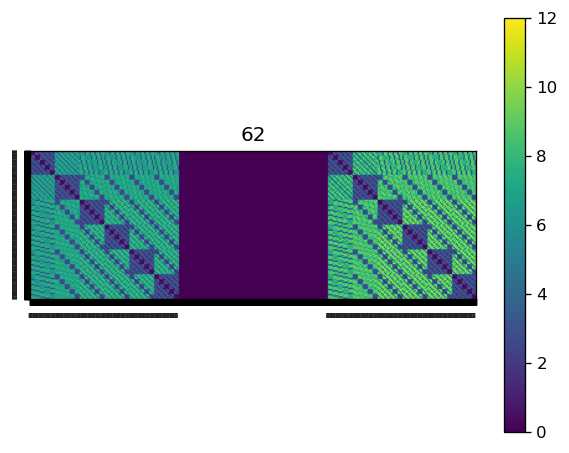

6 3
A_6A_3= 2A_3 + 8A_4 + 15A_5 + 16A_6 + 


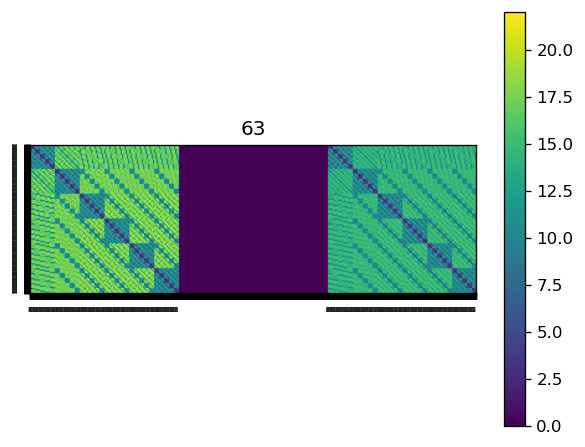

6 4
A_6A_4= 9A_2 + 27A_3 + 44A_4 + 51A_5 + 60A_6 + 


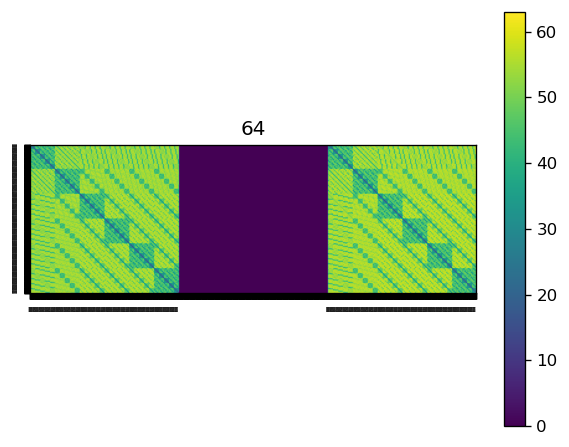

6 5
A_6A_5= 88A_2 + 99A_3 + 96A_4 + 98A_5 + 96A_6 + 


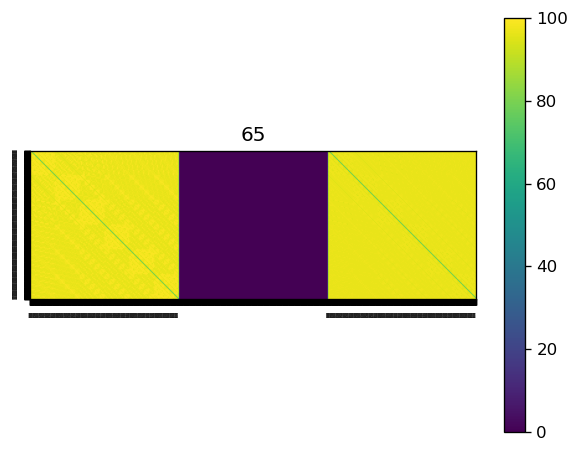

6 6
A_6A_6= 265A_0 + 168A_2 + 137A_3 + 116A_4 + 96A_5 + 80A_6 + 


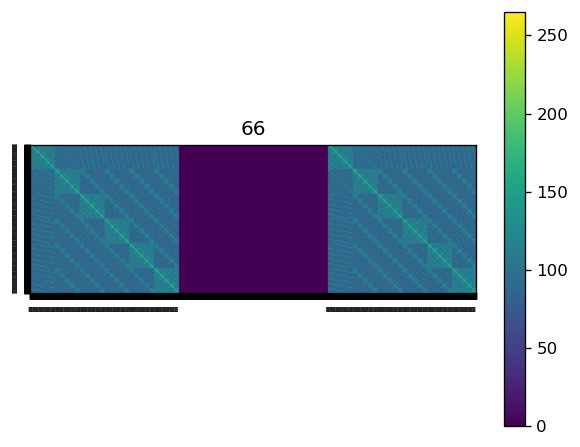

In [12]:
from random import shuffle

from numpy.linalg import norm


def hamming_scheme(rows, columns=None):
    if columns is None:
        columns = rows
    n = len(rows[0])
    mats = [np.zeros((len(rows), len(columns))) for _ in range(n + 1)]
    for i, r in enumerate(rows):
        for j, c in enumerate(columns):
            mats[dist(r, c)][i, j] = 1
    return mats


def is_association_scheme(scheme):
    shape = scheme[0].shape
    if norm(scheme[0] - np.eye(shape[0])):
        print("no identity")
        return False

    if norm(np.sum(scheme, axis=0) - np.ones(shape)):
        print("not all ones")
        return False

    for mat1 in scheme:
        for mat2 in scheme:
            if norm(mat1 @ mat2 - mat2 @ mat1):
                print("does not commute")
                visualize(mat1 + 1j * mat2)
                return False
    return True


def decompose_scheme(scheme, mask):
    scheme = copy(scheme)
    I = scheme[0]
    scheme = scheme[1:]
    return (
        [I]
        + [mask * A for A in scheme]
        + [(np.ones(mask.shape) - mask) * A for A in scheme]
    )


def decomp_hamming_scheme(instances, mask):
    return decompose_scheme(hamming_scheme(instances), mask)


def get_pvals(perms):
    plen = len(perms[0])
    print("plen", plen)
    print(perms[0])
    pvals = np.zeros([plen + 1, plen + 1, plen + 1])
    perm1 = perms[0]
    is_done = np.zeros(plen + 1)
    for perm2 in perms:
        k = dist(perm1, perm2)
        if not is_done[k]:
            for perm3 in perms:
                i = dist(perm1, perm3)
                j = dist(perm2, perm3)
                pvals[i, j, k] += 1
            is_done[k] = True
    print("done", is_done)
    return pvals


def get_mult_from_pvals(pvals, scheme, i, j):
    curr_sum = np.zeros(scheme[0].shape)
    for k in range(pvals[0].shape[0]):
        curr_sum = curr_sum + pvals[i, j, k] * scheme[k]
    return curr_sum


def print_linear_combo(pvals, scheme, i, j):
    print("A_" + str(i) + "A_" + str(j) + "=", end=" ")
    for k in range(pvals.shape[0]):
        if pvals[i, j, k] != 0:
            print(str(int(pvals[i, j, k])) + "A_" + str(k) + " +", end=" ")
    print("")


scheme = hamming_scheme(perms)
print(is_association_scheme(scheme))
pvals = get_pvals(perms)
perm2 = copy(perms)
shuffle(perm2)
pvals2 = get_pvals(perm2)
print(pvals - pvals2)
# print(perms, perms2)
for i in range(0, len(scheme)):
    A = scheme[i]
    for j in range(0, i + 1):
        B = scheme[j]
        print(i, j)
        print_linear_combo(pvals, scheme, i, j)
        visualize(
            A @ B + 1j * get_mult_from_pvals(pvals, scheme, i, j),
            labels,
            title=str(i) + str(j),
        )

In [ ]:
for i, mat in enumerate(scheme):
    visualize(mat * G, labels, title=str(i))

In [ ]:
def get_stablizers(perms, stable_sets):
    stabilizers = []
    for perm in perms:
        stable_count = 0
        for stable in stable_sets:
            if set(perm[stable] for stable in stable) != stable:
                break
            stable_count += 1
        if stable_count == len(stable_sets):
            stabilizers.append(perm)
    return stabilizers


stable_sets = [set(range(n)), set(range(n, perm_len))]
stabilizers = get_stablizers(perms, stable_sets)
print(stabilizers)